In [34]:
import pandas as pd

url = "https://raw.githubusercontent.com/GrandmaCan/ML/main/Classification/Diabetes_Data.csv"
data = pd.read_csv(url)
data

,Age,Weight,BloodSugar,Gender,Diabetes
0,25,119,130.8,男生,1
1,66,102,128.1,女生,1
2,59,65,103.9,男生,0
3,46,117,94.8,女生,0
4,45,79,57.8,男生,0
...,...,...,...,...,...
395,72,63,97.1,女生,0
396,22,117,156.7,女生,1
397,31,76,119.0,男生,0
398,36,65,96.3,女生,1


In [35]:
#label encoding
data['Gender'] = data['Gender'].map({'男生':1, '女生':0})
data

,Age,Weight,BloodSugar,Gender,Diabetes
0,25,119,130.8,1,1
1,66,102,128.1,0,1
2,59,65,103.9,1,0
3,46,117,94.8,0,0
4,45,79,57.8,1,0
...,...,...,...,...,...
395,72,63,97.1,0,0
396,22,117,156.7,0,1
397,31,76,119.0,1,0
398,36,65,96.3,0,1


In [36]:
#訓練集和測試集
from sklearn.model_selection import train_test_split

x = data[['Age','Weight','BloodSugar','Gender']]
y = data['Diabetes']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=87)
#預設為隨機分割資料 若想要分割的資料集為固定的可加上random_state並指定一數字(自訂)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
#轉換為矩陣型式方便計算

In [37]:
#使用標準化((x-x.mean())/標準差)做特徵縮放
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)#計算標準差
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
#最終明顯加快了gradient descent的速度

In [38]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [39]:
from torch import nn

class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=4, out_features=1, dtype=torch.float64)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.linear_layer(x))

In [40]:
torch.manual_seed(87)
model = LogisticRegressionModel()
model, model.state_dict()

(LogisticRegressionModel(
   (linear_layer): Linear(in_features=4, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 OrderedDict([('linear_layer.weight',
               tensor([[-0.4710,  0.1380, -0.1459, -0.1397]], dtype=torch.float64)),
              ('linear_layer.bias', tensor([-0.4544], dtype=torch.float64))]))

In [41]:
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [42]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

x_train

tensor([[-0.1305, -0.1202,  0.3527,  0.9393],
        [-0.4920, -0.0774, -0.6135,  0.9393],
        [-1.2753, -0.2916, -0.3567, -1.0646],
        ...,
        [-0.3113, -1.1912,  0.7662,  0.9393],
        [-0.4318, -1.4483, -1.5187,  0.9393],
        [ 1.1951,  0.8651, -0.3306, -1.0646]], dtype=torch.float64)

In [ ]:
model(x_train)

In [44]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1, 1)
y_train = y_train.type(torch.double)
y_test = y_test.type(torch.double)

In [45]:
cost_fn = nn.BCELoss()
y_pred = model(x_train)
cost = cost_fn(y_pred, y_train)
print(model.state_dict())
print(cost)

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
optimizer.zero_grad()
cost.backward()
optimizer.step()
print(model.state_dict())
print(cost)

OrderedDict([('linear_layer.weight', tensor([[-0.4710,  0.1380, -0.1459, -0.1397]], dtype=torch.float64)), ('linear_layer.bias', tensor([-0.4544], dtype=torch.float64))])
tensor(0.7056, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
OrderedDict([('linear_layer.weight', tensor([[-0.4697,  0.1394, -0.1422, -0.1394]], dtype=torch.float64)), ('linear_layer.bias', tensor([-0.4552], dtype=torch.float64))])
tensor(0.7056, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)


In [46]:
epochs = 10000

train_cost_hist = []
test_cost_hist = []
train_acc_hist = []#現在是分類問題 因此多一個hist來記錄在訓練資料的預測準確率
test_acc_hist = []#現在是分類問題 因此多一個hist來記錄在測試資料的預測準確率

for epoch in range(epochs):
    model.train()#現在是訓練階段
    y_pred = model(x_train)
    train_cost = cost_fn(y_pred, y_train)
    train_cost_hist.append(train_cost.detach().numpy())#detach()將有追蹤梯度的張量轉換成沒有追蹤梯度的張量(用於繪圖)
    
    train_acc = (torch.round(y_pred)==y_train).sum() / len(y_train) *100
    train_acc_hist.append(train_acc.detach().numpy())
    
    optimizer.zero_grad()
    train_cost.backward()
    optimizer.step()
    
    model.eval()#現在是測試階段
    with torch.inference_mode():#測試階段程式碼不需要追蹤梯度以提升運算速度
        test_pred = model(x_test)
        test_cost = cost_fn(test_pred, y_test)
        test_cost_hist.append(test_cost.detach().numpy())#detach()將有追蹤梯度的張量轉換成沒有追蹤梯度的張量(用於繪圖)
        
        test_acc = (torch.round(test_pred)==y_test).sum() / len(y_test) *100
        test_acc_hist.append(test_acc.detach().numpy())
    
    if epoch%1000==0:
        #print(f'Epoch: {epoch:5},  Train_Cost: {train_cost: .4e}, Test_Cost: {test_cost: .4e}')
        print(f'Epoch: {epoch:5},  Train_Acc: {train_acc}%, Test_Acc: {test_acc}%')

Epoch:     0,  Train_Acc: 54.6875%, Test_Acc: 51.25%
Epoch:  1000,  Train_Acc: 88.4375%, Test_Acc: 85.0%
Epoch:  2000,  Train_Acc: 88.75%, Test_Acc: 85.0%
Epoch:  3000,  Train_Acc: 90.0%, Test_Acc: 85.0%
Epoch:  4000,  Train_Acc: 89.6875%, Test_Acc: 85.0%
Epoch:  5000,  Train_Acc: 89.6875%, Test_Acc: 86.25%
Epoch:  6000,  Train_Acc: 89.6875%, Test_Acc: 88.75%
Epoch:  7000,  Train_Acc: 89.6875%, Test_Acc: 88.75%
Epoch:  8000,  Train_Acc: 89.375%, Test_Acc: 88.75%
Epoch:  9000,  Train_Acc: 89.375%, Test_Acc: 90.0%


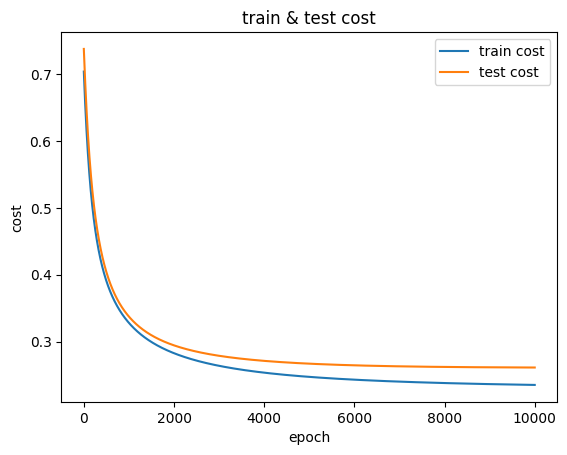

In [47]:
#繪製訓練集和測試集cost下降情形
import matplotlib.pyplot as plt
plt.plot(range(0,10000), train_cost_hist, label='train cost')
plt.plot(range(0,10000), test_cost_hist, label='test cost')
plt.title('train & test cost')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend()
plt.show()

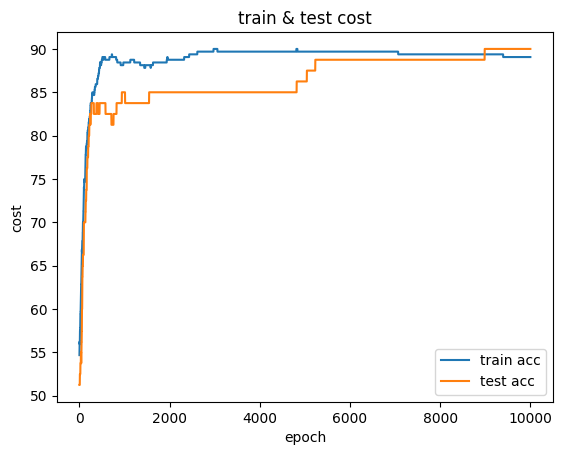

In [48]:
#繪製訓練集和測試集cost下降情形
import matplotlib.pyplot as plt
plt.plot(range(0,10000), train_acc_hist, label='train acc')
plt.plot(range(0,10000), test_acc_hist, label='test acc')
plt.title('train & test cost')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend()
plt.show()

In [54]:
model.state_dict()

OrderedDict([('linear_layer.weight',
              tensor([[-0.1825, -0.1210,  3.6459, -0.0998]], dtype=torch.float64)),
             ('linear_layer.bias', tensor([-1.8236], dtype=torch.float64))])

In [53]:
model.eval()
with torch.inference_mode():
    y_pred = model(x_test)
(torch.round(y_pred)==y_test).sum()/len(y_test)*100

tensor(90.)